In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from typing import Dict, List, Tuple

In [2]:
# linear transformation
def linear(in_array: np.ndarray, weight: np.ndarray, bias: np.ndarray) -> np.ndarray:
    r"""
    linear transformation: y = xW^T + b

    Args:
        in_array: input array
        weight: input weight
        bias: input bias

    Shapes:
        - Input: (N, in_features)
        - Weight: (out_features, in_features)
        - Bias: (out_features)
        - Output: (N, out_features)
    """

    assert weight.shape[-1] == in_array.shape[-1], "ERR : input and weight dimensions not matched."

    return np.matmul(in_array, weight.T) + bias

In [3]:
# polynomial transformation
def poly(in_array: np.ndarray, weight: np.ndarray, poly_deg: int=3) -> Tuple:
    """
    poly transformation: y = \sum_{i=0}^{n} a_ix^i

    Args:
        in_array: input array
        weight: coefficients in transformation
        poly_deg: the degree of polynomial

    Shapes:
        - Input: (N, in_features)
        - Weight: (depth, )
    """
    poly = PolynomialFeatures(poly_deg)
    base_items = poly.fit_transform(in_array)
    assert base_items.shape[-1] == weight.shape[-1], "shape of weight mismatches with polynomial shape."
    res = np.sum(base_items * weight, axis=1, keepdims=True)

    return res, base_items

def get_poly_dim(num_features: int, poly_deg: int) -> int:
    """test on simple polynomial to check the number of items """
    arr_test = np.zeros([1, num_features])
    poly = PolynomialFeatures(poly_deg)
    return poly.fit_transform(arr_test).shape[-1]


In [4]:
# base class
# TODO: abstract class for regression
class Module(object):
    def __init(self):
        pass

    def __call__(self):
        return

In [5]:
# initializers
def regression_initializer(size: Tuple, cate: str='normal') -> Dict:
    """initialize list with size `length`,default to `normal`

    for more details, check: https://blog.csdn.net/kane7csdn/article/details/108896031
    """
    assert size is not None, "size is None."

    cate_type = cate.lower()
    initial_list = ['normal', 'uniform', 'zeros', 'ones', 'xavier_normal', 'xavier_uniform']
    assert cate_type in initial_list, NotImplemented

    if cate == 'normal':
        return {
            'W': np.random.normal(loc=0., scale=1., size=size),
            'b': np.random.normal(loc=0., scale=1., size=size[0])
        }
    elif cate == 'uniform':
        a = 1. / size[-1]
        return {
            'W': np.random.uniform(low=-a, high=a, size=size),
            'b': np.random.uniform(low=-a, high=a, size=size[0])
        }
    elif cate == 'zeros':
        a = 1. / size[-1]
        return {
            'W': np.zeros(size),
            'b': np.zeros(size[0])
        }
    elif cate == 'ones':
        a = 1. / size[-1]
        return {
            'W': np.ones(size),
            'b': np.ones(size[0])
        }
    elif cate == 'xavier_normal':
        std = np.sqrt(2. / (size[0] + size[-1]))
        return {
            'W': np.random.normal(loc=0., scale=std, size=size),
            'b': np.random.normal(loc=0., scale=std, size=size[0])
        }
    elif cate == 'xavier_uniform':
        a = np.sqrt(6. / (size[0] + size[-1]))
        return {
            'W': np.random.uniform(low=-a, high=a, size=size),
            'b': np.random.uniform(low=-a, high=a, size=size[0])
        }
    else:
        assert NotImplemented

In [6]:
# loss functions
def mean_squared_error(y_pred: np.ndarray, y_std: np.ndarray, n: int):
    """Mean Squared Error, a.k.a MSE"""
    return np.sum((y_pred - y_std)**2) / n

def loss_fn(cate: str='mse'):
    """loss functions"""
    if cate=='mse':
        return mean_squared_error
    else:
        return NotImplemented

In [7]:
# optimizers
def SGD(dw: np.ndarray, db: np.ndarray, lr: int,
        weight: np.ndarray, bias: np.ndarray,
        **kwargs) -> Dict:
    """Stochastic Gradient Descent"""
    epoch = kwargs['epoch']
    epoch += 1
    return {
        'weight_updated': weight - lr * dw,
        'bias_updated': bias - lr * db,
        'epoch': epoch
    }

def momentum(dw: np.ndarray, db: np.ndarray, lr: int,
             weight: np.ndarray, bias: np.ndarray,
             **kwargs) -> Dict:
    """Momentum Gradient Descent"""

    prev_mm_w = kwargs['prev_mm_w']
    prev_mm_b = kwargs['prev_mm_b']
    epoch = kwargs['epoch']

    beta = 0.9
    cur_mm_w = beta * prev_mm_w - (1 - beta) * dw
    cur_mm_b = beta * prev_mm_b - (1 - beta) * db
    cur_mm_w /= (1 - beta**epoch)
    cur_mm_b /= (1 - beta**epoch)
    epoch += 1

    return {
        'weight_updated': weight - lr * cur_mm_w,
        'bias_updated' : bias - lr * cur_mm_b,
        'prev_mm_w' : cur_mm_w,
        'prev_mm_b' : cur_mm_b,
        'epoch': epoch
    }

def RMSprop(dw: np.ndarray, db: np.ndarray, lr: int,
        weight: np.ndarray, bias: np.ndarray,
        **kwargs):
    """RMSprop Gradient Descent"""
    prev_s_w = kwargs['prev_s_w']
    prev_s_b = kwargs['prev_s_b']
    epoch = kwargs['epoch']

    beta = 0.9
    epsilon = 1e-6
    cur_s_w = beta * prev_s_w + (1 - beta) * dw**2
    cur_s_b = beta * prev_s_b + (1 - beta) * db**2
    cur_s_w /= (1 - beta**epoch)
    cur_s_b /= (1-  beta**epoch)

    return {
        'weight_updated': weight - lr / np.sqrt(cur_s_w + epsilon) * dw,
        'bias_updated' : bias - lr / np.sqrt(cur_s_b + epsilon) * db,
        'prev_s_w': cur_s_w,
        'prev_s_b': cur_s_b,
        'epoch': epoch
    }

def Adam(dw: np.ndarray, db: np.ndarray, lr: int,
        weight: np.ndarray, bias: np.ndarray,
        **kwargs):
    """Adam Gradient Descent"""
    prev_mm_w = kwargs['prev_mm_w']
    prev_mm_b = kwargs['prev_mm_b']
    prev_s_w = kwargs['prev_s_w']
    prev_s_b = kwargs['prev_s_b']
    epoch = kwargs['epoch']

    beta = 0.9
    epsilon = 1e-6
    cur_mm_w = beta * prev_mm_w - (1 - beta) * dw
    cur_mm_b = beta * prev_mm_b - (1 - beta) * db
    cur_mm_w /= (1 - beta**epoch)
    cur_mm_b /= (1 - beta**epoch)
    cur_s_w = beta * prev_s_w + (1 - beta) * dw**2
    cur_s_b = beta * prev_s_b + (1 - beta) * db**2
    cur_s_w /= (1 - beta**epoch)
    cur_s_b /= (1-  beta**epoch)

    return {
        'weight_updated': weight - lr * cur_mm_w / (np.sqrt(cur_s_w) + epsilon) * dw,
        'bias_updated' : bias - lr * cur_mm_b / (np.sqrt(cur_s_b) + epsilon) * db,
        'prev_mm_w' : cur_mm_w,
        'prev_mm_b' : cur_mm_b,
        'prev_s_w': cur_s_w,
        'prev_s_b': cur_s_b,
        'epoch': epoch
    }

def optimizer(cate: str='SGD'):
    """optimizers"""
    assert cate is not None, "Optimizer not selected"
    cate_type = cate.lower()
    optimizer_list = ['sgd', 'momentum', 'rmsprop', 'adam']
    assert  cate_type in optimizer_list, NotImplemented

    if cate_type == 'sgd':
        return SGD
    elif cate_type == 'momentum':
        return momentum
    elif cate_type == 'rmsprop':
        return RMSprop
    elif cate_type == 'adam':
        return Adam
    else:
        return NotImplemented


In [8]:
def get_optional_args(optimizer_type: str='SGD') -> Dict:
    """fill in optional arguments for different optimizers"""
    assert optimizer_type is not None, "Optimizer not selected"
    cate_type = optimizer_type.lower()
    optimizer_list = ['sgd', 'momentum', 'rmsprop', 'adam']
    assert  cate_type in optimizer_list, NotImplemented

    optional_args = {}
    optional_args['epoch'] = 1
    if optimizer_type == 'momentum':
        optional_args['prev_mm_w'] = 0
        optional_args['prev_mm_b'] = 0
    elif optimizer_type == 'rmsprop':
        optional_args['prev_s_w'] = 0
        optional_args['prev_s_b'] = 0
    elif optimizer_type == 'adam':
        optional_args['prev_mm_w'] = 0
        optional_args['prev_mm_b'] = 0
        optional_args['prev_s_w'] = 0
        optional_args['prev_s_b'] = 0
    return optional_args

In [67]:
loss_log = []

In [68]:
class LinearRegression(Module):
    """
    linear transformations: y = xW^T + b,
    initializer default to `normal`,


    Args:
        in_array: feature array

    Shapes:
        in_array: (N, in_features)
        out_array: (N, )
    """
    def __init__(self, in_array: np.ndarray,
                 initializer_type: str='normal',
                 loss_fn_type: str='mse',
                 lr: float=0.001,
                 optimizer_type: str='SGD'):
        # NOTICE: check in_array for batch case
        super().__init__()
        self.in_array = in_array
        self.batch_size = in_array.shape[0]
        self.in_features = in_array.shape[-1]
        self.out_features = 1

        self.lr = lr
        self.optimizer = optimizer(optimizer_type)
        self.optional_args = get_optional_args(optimizer_type)
        self.initial = regression_initializer((self.out_features,
                                               self.in_features),
                                               initializer_type)
        self.weight = self.initial['W']
        self.bias = self.initial['b']

        self.loss_fn = loss_fn(loss_fn_type)
        self.loss = 99999

        self.dw = 0
        self.db = 0

        self.y_pred = np.array([])
        self.cache = {}

    def forward(self) -> np.ndarray:
        self.y_pred = linear(self.in_array, self.weight, self.bias)
        return self.y_pred

    def loss_reg(self, y_std):
        self.loss = self.loss_fn(self.y_pred, y_std, self.batch_size)
        loss_log.append(self.loss)

    def backward(self, y_std):
        diff = self.y_pred - y_std
        self.dw = (1. / self.batch_size) * np.sum(self.in_array * diff, axis=0)
        self.db = (1. / self.batch_size) * np.sum(diff)

    def step(self):
        param_updated = self.optimizer(self.dw, self.db, self.lr, self.weight, self.bias, **self.optional_args)
        self.weight = param_updated['weight_updated']
        self.bias = param_updated['bias_updated']

        for opt_arg in self.optional_args.keys():
            self.optional_args[opt_arg] = param_updated[opt_arg]

    def print_params(self):
        # print(f"weight: {self.weight} \nbias: {self.bias} \nloss: {self.loss}")
        print(f"loss: {self.loss}")

    def __name__(self):
        return "Linear Regression Model"


In [10]:
class PolyRegression(Module):
    """
    Polynomial transformations: y = xW^T + b,
    initializer default to `normal`,


    Args:
        in_array: feature array

    Shapes:
        in_array: (N, in_features)
        out_array: (N, )
    """
    def __init__(self, in_array: np.ndarray,
                 initializer_type: str='normal',
                 loss_fn_type: str='mse',
                 lr: float=0.00001,
                 optimizer_type: str='SGD',
                 poly_deg: int=3):
        # NOTICE: check in_array for batch case
        super().__init__()
        self.in_array = in_array
        self.batch_size = in_array.shape[0]
        self.in_features = in_array.shape[-1]
        self.out_features = 1
        self.optional_args = get_optional_args(optimizer_type)

        self.lr = lr
        self.poly_deg = poly_deg
        self.optimizer = optimizer(optimizer_type)
        # for initialization in the view of math, check out : https://math.stackexchange.com/questions/2928712/number-of-elements-in-polynomial-of-degree-n-and-m-variables
        self.weight_dim = get_poly_dim(self.in_features, poly_deg)
        self.initial = regression_initializer((self.out_features,
                                               self.weight_dim),
                                               initializer_type)
        self.weight = self.initial['W']

        self.loss_fn = loss_fn(loss_fn_type)
        self.loss = 99999

        self.dw = 0

        self.cache_poly_matrix = np.array([])
        self.y_pred = np.array([])

    def forward(self) -> np.ndarray:
        self.y_pred, self.cache_poly_matrix = poly(self.in_array,
                                                   self.weight,
                                                   self.poly_deg)
        return self.y_pred

    def loss_reg(self, y_std):
        self.loss = self.loss_fn(self.y_pred, y_std, self.batch_size)

    def backward(self, y_std):
        diff = self.y_pred - y_std
        self.dw = (2. / self.batch_size) * np.sum(diff * self.cache_poly_matrix, axis=0)

    def step(self):
        param_updated = self.optimizer(self.dw, 0, self.lr, self.weight, 0, **self.optional_args)
        self.weight = param_updated['weight_updated']

        for opt_arg in self.optional_args.keys():
            self.optional_args[opt_arg] = param_updated[opt_arg]

    def print_params(self):
        # print(f"weight: {self.weight} \nbias: {self.bias} \nloss: {self.loss}")
        print(f"loss: {self.loss}")

    def __name__(self):
        return "Polynomial Regression Model"


In [11]:
def training(model, labels, epochs: int=100, isLinear: int=False) -> Dict:
    """Training loop

    Args:
        model: regression model
        labels: target labels
        epochs: training epochs
        isLinear: Linear Regression or not (bias in result)
    """
    result = {}

    for epoch in range(epochs):
        model.forward()
        model.backward(labels)
        model.loss_reg(labels)
        model.step()
        print(f"Epoch: {epoch}", end=" ")
        model.print_params()

    result['name'] = model.__class__.__name__
    result['weight'] = model.weight
    if isLinear:
        result['bias'] = model.bias
    result['loss'] = model.loss
    return result

## Synthetic Test

### Linear

In [69]:
def synthetic_linear_data(w,b,num_examples):
    X = np.random.normal(0,1,(num_examples,len(w[0])))
    y = np.matmul(X,w.T) + b
    y += np.random.normal(0,0.3,y.shape)
    return X, y.reshape((-1,1))

true_w = np.array([[1.2]])
true_b = [[4.2]]
features, labels = synthetic_linear_data(true_w,true_b,1000)

In [159]:
loss_reg_all = []  # 0.01, 0.001, 0.0001, 0.00001, 0.000001
lr_test = [0.1, 0.05, 0.01, 0.005, 0.001]
for lr_i in lr_test:
    loss_log = []
    linear_reg = LinearRegression(features, lr=lr_i, optimizer_type='sgd', initializer_type='ones')
    training_res = training(linear_reg, labels, epochs=1000, isLinear=True)
    loss_reg_all.append(loss_log)

Epoch: 0 loss: 10.403824827888338
Epoch: 1 loss: 8.444106728092988
Epoch: 2 loss: 6.856854660874072
Epoch: 3 loss: 5.571276107415122
Epoch: 4 loss: 4.530033932324438
Epoch: 5 loss: 3.6866888978363397
Epoch: 6 loss: 3.0036282932829304
Epoch: 7 loss: 2.450388279268537
Epoch: 8 loss: 2.002295109834084
Epoch: 9 loss: 1.6393646210692372
Epoch: 10 loss: 1.3454108957770479
Epoch: 11 loss: 1.1073243449323427
Epoch: 12 loss: 0.9144870041019794
Epoch: 13 loss: 0.75829896387615
Epoch: 14 loss: 0.6317948107660777
Epoch: 15 loss: 0.5293329701165821
Epoch: 16 loss: 0.44634409448290674
Epoch: 17 loss: 0.3791272747014069
Epoch: 18 loss: 0.32468498403819296
Epoch: 19 loss: 0.2805893934889755
Epoch: 20 loss: 0.24487409559893478
Epoch: 21 loss: 0.21594640749471056
Epoch: 22 loss: 0.1925163417276473
Epoch: 23 loss: 0.17353907696427232
Epoch: 24 loss: 0.15816836268959328
Epoch: 25 loss: 0.1457187797703978
Epoch: 26 loss: 0.13563517371315276
Epoch: 27 loss: 0.12746789736317368
Epoch: 28 loss: 0.120852758898

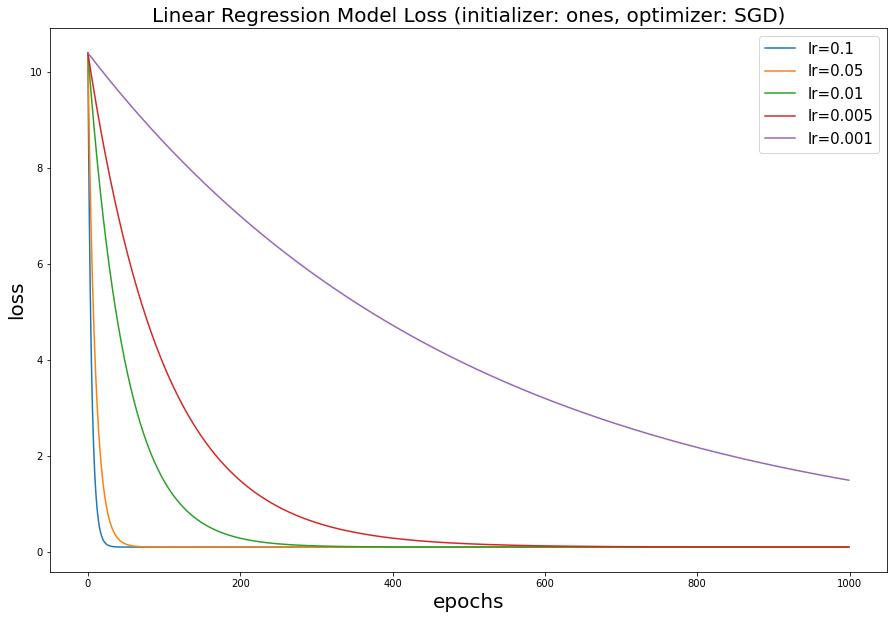

In [160]:
plt.figure(figsize=(15, 10))
epochs = [i for i in range(len(loss_log))]
plt.xlabel("epochs", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.title("Linear Regression Model Loss (initializer: ones, optimizer: SGD)", fontsize=20)
for loss_log_i in loss_reg_all:
    plt.plot(epochs, loss_log_i)
    plt.legend(["lr=0.1", "lr=0.05", "lr=0.01", "lr=0.005", "lr=0.001"], prop = {'size':15})
plt.savefig('linear_regression_model_loss_to_epochs(lr).jpg')

In [166]:
loss_reg_all = []  # 0.01, 0.001, 0.0001, 0.00001, 0.000001
opt_list = ['sgd', 'rmsprop', 'adam']
for opt_i in opt_list:
    loss_log = []
    linear_reg = LinearRegression(features, lr=0.0001, optimizer_type=opt_i, initializer_type='ones')
    training_res = training(linear_reg, labels, epochs=10, isLinear=True)
    loss_reg_all.append(loss_log)

Epoch: 0 loss: 10.403824827888338
Epoch: 1 loss: 10.401762032868405
Epoch: 2 loss: 10.399699650527586
Epoch: 3 loss: 10.397637680783319
Epoch: 4 loss: 10.395576123553063
Epoch: 5 loss: 10.393514978754284
Epoch: 6 loss: 10.391454246304477
Epoch: 7 loss: 10.389393926121143
Epoch: 8 loss: 10.387334018121798
Epoch: 9 loss: 10.385274522223988
Epoch: 0 loss: 10.403824827888338
Epoch: 1 loss: 10.403142582976136
Epoch: 2 loss: 10.402926858319267
Epoch: 3 loss: 10.402855348500733
Epoch: 4 loss: 10.402831526681956
Epoch: 5 loss: 10.40282358664139
Epoch: 6 loss: 10.402820939984213
Epoch: 7 loss: 10.40282005776624
Epoch: 8 loss: 10.402819763693646
Epoch: 9 loss: 10.402819665669453
Epoch: 0 loss: 10.403824827888338
Epoch: 1 loss: 10.401762033550602
Epoch: 2 loss: 10.395240914007655
Epoch: 3 loss: 10.375587884323116
Epoch: 4 loss: 10.316761618295278
Epoch: 5 loss: 10.14178398947649
Epoch: 6 loss: 9.630284595332625
Epoch: 7 loss: 8.211932672471487
Epoch: 8 loss: 4.881109229817493
Epoch: 9 loss: 0.534

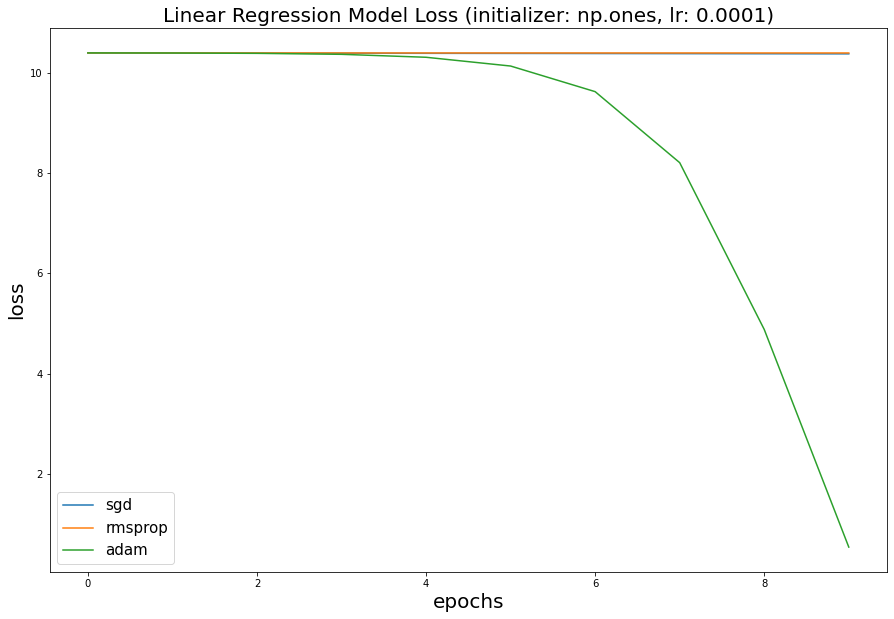

In [167]:
plt.figure(figsize=(15, 10))
epochs = [i for i in range(len(loss_log))]
plt.xlabel("epochs", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.title("Linear Regression Model Loss (initializer: np.ones, lr: 0.0001)", fontsize=20)
for loss_log_i in loss_reg_all:
    plt.plot(epochs, loss_log_i)
    plt.legend(['sgd', 'rmsprop', 'adam'], prop = {'size':15})
plt.savefig('linear_regression_model_loss_to_epochs(optimizer).jpg')

In [34]:
training_res

{'name': 'LinearRegression',
 'weight': array([[1.18326039]]),
 'bias': array([4.19939606]),
 'loss': 0.09418713802447212}

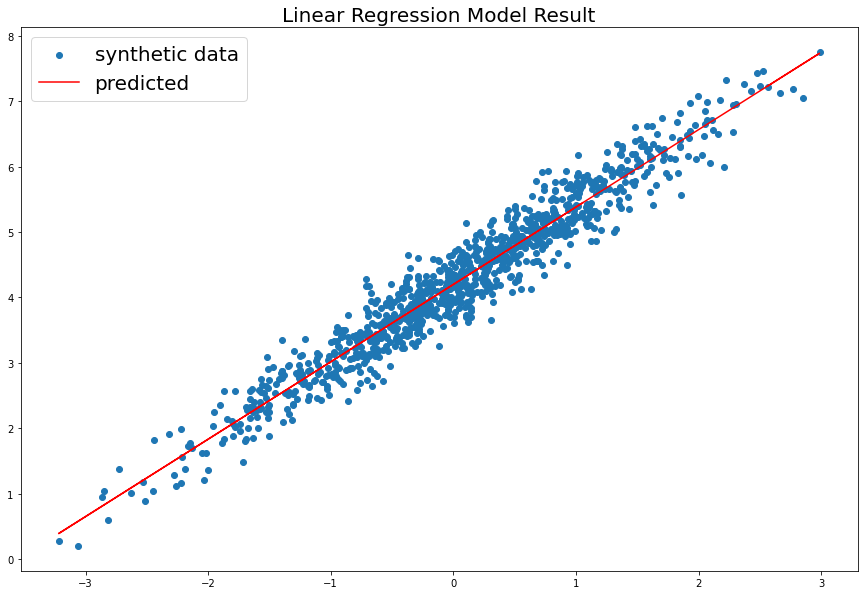

In [55]:
plt.figure(figsize=(15, 10))
plt.scatter(features, labels)
linear_fn =lambda x: x * training_res['weight'].item() + training_res['bias'].item()
syn_res = [linear_fn(i) for i in features]
plt.plot(features, syn_res, c='r')
plt.title("Linear Regression Model Result", fontsize=20)
plt.legend(['synthetic data', 'predicted'], prop = {'size':20})
plt.savefig('linear_model_synthetic_dataset.jpg')

### Non-linear

In [58]:
def synthetic_poly_data():
    x = np.linspace(0, 1, 100)
    y = np.sin(5 * x) + 0.1 + np.random.randn(len(x)) * 0.1
    return x, y

syn_poly_data = synthetic_poly_data()
poly_features = syn_poly_data[0][:, np.newaxis]
poly_labels = syn_poly_data[1][:, np.newaxis]

In [59]:
poly_reg = PolyRegression(poly_features, lr=0.1, poly_deg=10, optimizer_type='SGD')
poly_training_res = training(poly_reg, poly_labels, epochs=10000)

Epoch: 0 loss: 1.9022414905511476
Epoch: 1 loss: 1.1922842376014102
Epoch: 2 loss: 0.8745842562349921
Epoch: 3 loss: 0.7210812004076481
Epoch: 4 loss: 0.6378115282042492
Epoch: 5 loss: 0.5858451025220734
Epoch: 6 loss: 0.5488687937749274
Epoch: 7 loss: 0.5198910700690532
Epoch: 8 loss: 0.49578509001669
Epoch: 9 loss: 0.47504568884561543
Epoch: 10 loss: 0.45686458291183224
Epoch: 11 loss: 0.44074666687305547
Epoch: 12 loss: 0.4263487642295033
Epoch: 13 loss: 0.413410131273151
Epoch: 14 loss: 0.401721060483333
Epoch: 15 loss: 0.3911075207759016
Epoch: 16 loss: 0.3814227308530115
Epoch: 17 loss: 0.3725418822156101
Epoch: 18 loss: 0.364358416592078
Epoch: 19 loss: 0.35678116585674247
Epoch: 20 loss: 0.3497320382640156
Epoch: 21 loss: 0.3431440935428558
Epoch: 22 loss: 0.33695991847812656
Epoch: 23 loss: 0.331130246365247
Epoch: 24 loss: 0.32561277968905555
Epoch: 25 loss: 0.32037118444234536
Epoch: 26 loss: 0.31537423037156836
Epoch: 27 loss: 0.3105950556890434
Epoch: 28 loss: 0.3060105381

In [60]:
poly_training_res

{'name': 'PolyRegression',
 'weight': array([[ 0.36378184,  3.16405537, -3.13549206, -3.06904324, -0.87799048,
         -1.38264578,  0.31971563,  1.35934368,  1.88588701, -0.05626168,
          0.88270087]]),
 'loss': 0.02327417657968127}

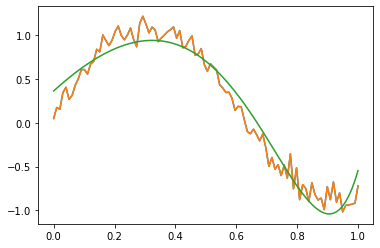

In [61]:
# poly_training_res
plt.plot(poly_features, poly_labels)

def getY_Hat(x, theta):
    # 根据 theta 作为系数，生成多项式函数
    f = np.poly1d(theta)
    return f(x)


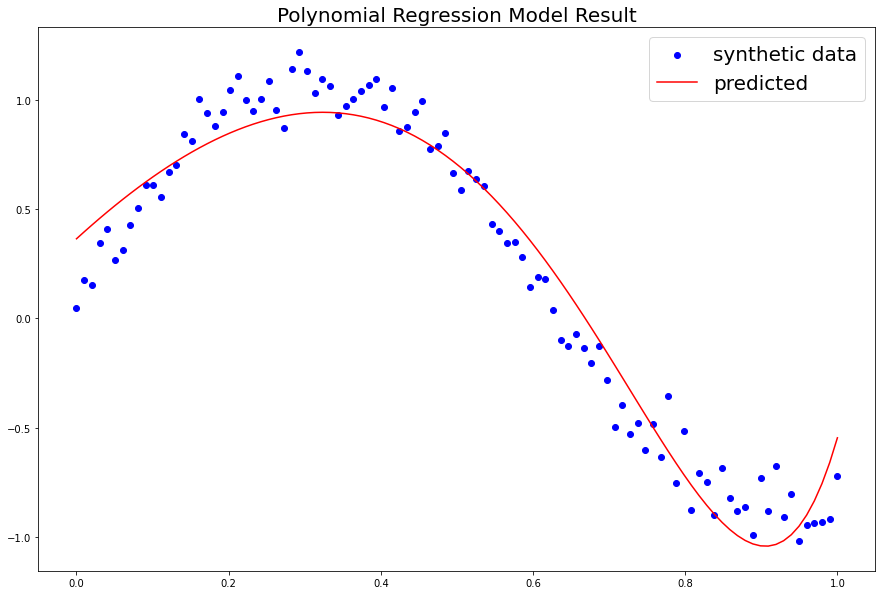

In [66]:
plt.figure(figsize=(15, 10))
plt.scatter(poly_features, poly_labels, c='b')
plt.title("Polynomial Regression Model Result", fontsize=20)
poly_res = getY_Hat(poly_features, np.flip(poly_training_res['weight'][0]))
plt.plot(poly_features, poly_res, c='r')
plt.legend(['synthetic data', 'predicted'], prop = {'size':20})
plt.savefig('polynomial_model_synthetic_dataset.jpg')

## Authentic Dataset

In [17]:
sheet = pd.read_csv('output_9301630.csv')
sheet

index         a         e         i        om         w         q  \
0            0 -0.029846 -0.895611  0.035828 -0.871575 -1.045872  0.302371   
1            1 -0.027679  1.093829  3.582539  0.031665  1.237434 -0.520651   
2            2 -0.095528  1.436801  0.386203  0.000245  0.639594 -0.812286   
3            3 -0.297618 -0.731735 -0.469255 -0.642731 -0.301053 -0.485692   
4            4 -0.157850  0.587956 -0.728912 -0.275048  1.707118 -0.620504   
...        ...       ...       ...       ...       ...       ...       ...   
137631  797860  0.234191  0.175758  2.450501  1.355319 -1.565887  0.511487   
137632  798077 -0.174819 -0.894811  0.182010  0.744511 -0.114080 -0.093109   
137633  798189  0.217787  0.967786  1.114461 -0.310050 -0.009712  0.096293   
137634  799752  0.155458  1.830068  0.600955  1.694918  1.551910 -0.442448   
137635  810375 -0.260804 -0.470316 -0.852000 -0.210127 -1.448048 -0.481700   

              ad   data_arc  condition_code  n_obs_used  diameter  class  \
0      -0.085269  -0.023760       -0.246789    0.548671   939.400      0   
1       0.063683  10.280279       -0.246789   13.113797   545.000      0   
2       0.044314  10.339673       -0.246789   10.788041   246.596      0   
3      -0.226383   2.486040       -0.246789   14.514957   525.400      0   
4      -0.055395   8.850443       -0.246789    3.760430   106.699      0   
...          ...        ...             ...         ...       ...    ...   
137631  0.155093  -1.070295        0.261837   -1.048818     3.793      0   
137632 -0.167225  -0.920349        0.770464   -1.077345     2.696      0   
137633  0.211838  -0.994673        0.261837   -1.053853     2.917      0   
137634  0.242311  -1.097071        0.770464   -1.087413     3.271      0   
137635 -0.188385  -0.894223        1.279091   -1.090769     1.600      0   

               n       per        ma  
0      -0.100997 -0.010812 -1.022562  
1      -0.107698 -0.010489 -1.193462  
2       0.111949 -0.020501 -1.433030  
3       0.912062 -0.049169 -0.843764  
4       0.333305 -0.029528  0.959753  
...          ...       ...       ...  
137631 -0.791726  0.029889 -0.175197  
137632  0.397162 -0.031957 -0.365503  
137633 -0.755178  0.027281 -0.082262  
137634 -0.609446  0.017466 -0.071639  
137635  0.747222 -0.044078 -0.118250  

[137636 rows x 16 columns]

In [18]:
sheet.drop('index', axis=1, inplace=True)
label = sheet['diameter']
dia_dropped = sheet.drop('diameter', axis=1)
feature = dia_dropped

# labels & features
label_a = np.array(label)[:1000][:, np.newaxis]
feature_a = np.array(feature)[:1000]

## Linear Model

In [27]:
linear_reg_asteroids = LinearRegression(feature_a, lr=0.01)
training_res = training(linear_reg_asteroids, label_a, 1000)

Epoch: 0 loss: 9524.313262275238
Epoch: 1 loss: 5265.443416119594
Epoch: 2 loss: 3977.6487408126827
Epoch: 3 loss: 3581.7782206711568
Epoch: 4 loss: 3453.8274562011984
Epoch: 5 loss: 3406.5130594389716
Epoch: 6 loss: 3383.6211940800126
Epoch: 7 loss: 3368.2749855827537
Epoch: 8 loss: 3355.4035908498604
Epoch: 9 loss: 3343.4795686117095
Epoch: 10 loss: 3332.039081908181
Epoch: 11 loss: 3320.9376531389476
Epoch: 12 loss: 3310.126795936946
Epoch: 13 loss: 3299.5869735132983
Epoch: 14 loss: 3289.307474059321
Epoch: 15 loss: 3279.280367080979
Epoch: 16 loss: 3269.4986858343796
Epoch: 17 loss: 3259.9558782119793
Epoch: 18 loss: 3250.6456384218804
Epoch: 19 loss: 3241.561853052021
Epoch: 20 loss: 3232.698581561501
Epoch: 21 loss: 3224.0500471991822
Epoch: 22 loss: 3215.610631143913
Epoch: 23 loss: 3207.3748677011595
Epoch: 24 loss: 3199.337439903597
Epoch: 25 loss: 3191.4931753173523
Epoch: 26 loss: 3183.837041991929
Epoch: 27 loss: 3176.3641445328385
Epoch: 28 loss: 3169.0697202883593
Epoch:

In [21]:
training_res

{'name': 'LinearRegression',
 'weight': array([[ 2.35669987e-01, -1.17841901e+00,  1.63007706e+00,
         -1.72411614e+00,  5.32260809e-01,  8.60892564e-01,
          2.24566552e-01,  9.73853000e+00,  1.83543912e+00,
          4.48893100e+00,  1.81981661e-02, -2.12482016e+00,
          1.37352095e-03, -1.33924122e+00]]),
 'loss': 3262.309635775402}

## Polynomial Model

In [38]:
linear_reg_asteroids = PolyRegression(feature_a, lr=0.00001, poly_deg=3)
poly_training_res = training(linear_reg_asteroids, label_a, epochs=100)

Epoch: 0 loss: 27272.000826892294
Epoch: 1 loss: 22303.885816141472
Epoch: 2 loss: 19134.326471784963
Epoch: 3 loss: 16881.70919689522
Epoch: 4 loss: 15174.890977791309
Epoch: 5 loss: 13831.978074146122
Epoch: 6 loss: 12748.928701022234
Epoch: 7 loss: 11858.75140630037
Epoch: 8 loss: 11115.04919851306
Epoch: 9 loss: 10484.385509294636
Epoch: 10 loss: 9942.144938914133
Epoch: 11 loss: 9469.977107956258
Epoch: 12 loss: 9054.078727980122
Epoch: 13 loss: 8683.984061022322
Epoch: 14 loss: 8351.693202033963
Epoch: 15 loss: 8051.036611584105
Epoch: 16 loss: 7777.209170267934
Epoch: 17 loss: 7526.427384854172
Epoch: 18 loss: 7295.6765907599365
Epoch: 19 loss: 7082.524118068617
Epoch: 20 loss: 6884.980888976812
Epoch: 21 loss: 6701.398617952741
Epoch: 22 loss: 6530.3932131461
Epoch: 23 loss: 6370.7874831757845
Epoch: 24 loss: 6221.568088043792
Epoch: 25 loss: 6081.853017309192
Epoch: 26 loss: 5950.866864250633
Epoch: 27 loss: 5827.921887543203
Epoch: 28 loss: 5712.40338220796
Epoch: 29 loss: 56

In [39]:
poly_training_res

{'name': 'PolyRegression',
 'weight': array([[-7.96069235e-01,  6.65089634e-01, -2.33173941e-03,
          1.87009367e+00,  2.80651894e-01,  1.48281961e+00,
          6.55684797e-01, -2.02551324e-01, -1.22401761e-01,
         -5.71040590e-02,  1.23159470e+00, -4.76552614e-01,
         -4.95162742e-01, -4.19470580e-01,  8.71820870e-01,
         -2.51719328e-01, -7.46350739e-01,  1.14697038e+00,
          5.31090740e-01,  1.69158019e+00, -1.26116935e+00,
         -5.91020494e-02, -1.03679904e+00,  9.34526079e-01,
          9.64404518e-01,  3.85448479e-01,  1.16620727e+00,
          2.33174093e+00,  1.33792540e+00,  1.10086262e+00,
         -6.88887193e-02,  3.32885636e-02, -9.91066533e-01,
          9.16358050e-01,  3.01782958e-01, -9.90817370e-01,
         -1.62954452e+00, -8.55757583e-02, -2.77559710e-01,
          3.61029608e-01, -3.82404245e-01, -8.80498187e-01,
         -1.39784152e+00, -6.93949759e-01, -4.59812051e-01,
         -9.28635854e-01,  8.07114050e-01,  5.47391664e-01,
   